In [ ]:
#pip uninstall scikit-learn --yes
#pip uninstall imblearn --yes
#pip install scikit-learn==1.2.0
#pip install scikit-optimize
#pip install hyperopt==0.2.7
#pip install imblearn
#pip install scikit-plot
pip install -r requirements.txt

# Pacotes

In [66]:
# Bibliotecas padrão e de manipulação de data
from datetime import date
import pandas as pd
import numpy as np
from pytz import timezone

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

# Machine Learning - pré-processamento e métricas
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score, log_loss, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve

# Machine Learning - modelos e otimização
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree
import sklearn
import shap
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from skopt import forest_minimize
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Salvamento e carregamento de modelos
import pickle
import os

# Outras bibliotecas
import re

plt.style.use('ggplot')
print(xgb.__version__)
print(shap.__version__)
print(sklearn.__version__)
#print(hyperopt.__version__)

2.0.2
0.44.0
1.2.0


# Funções

In [58]:
def hipertunnig(space):
    """
    Realiza o ajuste de hiperparâmetros de um modelo XGBoost usando validação cruzada.

    Args:
    space (dict): Dicionário contendo os hiperparâmetros para teste no modelo XGBoost.

    Processo:
    1. Configura o modelo XGBoost com os hiperparâmetros do espaço fornecido.
    2. Cria um pipeline combinando SMOTE para balanceamento de classes e o classificador.
    3. Usa StratifiedKFold para divisão estratificada do conjunto de dados.
    4. Calcula a média da AUC (Area Under the ROC Curve) usando cross_val_score.
    
    Returns:
    dict: Dicionário contendo o 'loss' (negativo da média da AUC) e o 'status'.
    """
    # Configuração do modelo com os parâmetros do espaço
    clf = xgb.XGBClassifier(
        n_estimators=int(space['n_estimators']), 
        max_depth=int(space['max_depth']), 
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        eval_metric="auc"
    )

    # Pipeline com SMOTE e o classificador
    pipeline = make_pipeline(SMOTE(random_state=42), clf)

    # StratifiedKFold para manter a proporção de classes em cada fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Avaliação usando cross_val_score
    auc_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    mean_auc = auc_scores.mean()
    print("Média AUC: ", mean_auc)

    # A função de perda é o negativo da média do AUC
    return {'loss': -mean_auc, 'status': STATUS_OK}

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0}

## Dummies
def get_one_hot_enc(feature_col: pd.Series, enc: preprocessing.OneHotEncoder, column_name: str) -> pd.DataFrame:
    """
    Aplica codificação one-hot a uma coluna específica de um DataFrame.

    Args:
    feature_col (pd.Series): Coluna do DataFrame para ser codificada.
    enc (preprocessing.OneHotEncoder): Instância do OneHotEncoder treinada.
    column_name (str): Nome da coluna a ser codificada.

    Processo:
    1. Cria um DataFrame com a coluna especificada.
    2. Aplica a transformação one-hot usando o encoder fornecido.
    3. Retorna um DataFrame com as colunas codificadas.

    Returns:
    pd.DataFrame: DataFrame com as colunas resultantes da codificação one-hot.
    """
    unseen_df = pd.DataFrame(feature_col, columns=[column_name])
    encoded_vec = enc.transform(unseen_df).toarray()
    columns = enc.get_feature_names_out([column_name])
    encoded_df = pd.DataFrame(encoded_vec, columns=columns)
    return encoded_df


# Função para salvar um modelo em um arquivo pickle
def save_pickle(model, file_name: str):
    """
    Salva um objeto modelo em um arquivo pickle.

    Args:
    model (any): O modelo a ser salvo.
    file_name (str): Nome do arquivo pickle a ser criado.

    Processo:
    1. Abre o arquivo pickle em modo de escrita binária.
    2. Salva o objeto modelo no arquivo pickle.
    """
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

# Função para carregar um modelo de um arquivo pickle
def load_pickle(file_name: str) -> any:
    """
    Carrega um objeto a partir de um arquivo pickle.

    Args:
    file_name (str): Nome do arquivo pickle a ser carregado.

    Processo:
    1. Abre o arquivo pickle em modo de leitura binária.
    2. Carrega e retorna o objeto contido no arquivo pickle.

    Returns:
    any: Objeto carregado do arquivo pickle.
    """
    with open(file_name, 'rb') as file:
        return pickle.load(file)

In [5]:
#learning_rate=lr, 
#(1e-3, 1e-1, "log-uniform"),

# Dados

In [6]:
file_path = 'dados_tratados/historico_voo_tratados_train.csv'
df = pd.read_csv(file_path)

Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


In [7]:
df.head(3)

,nome_empresas,numero_voo,codigo_di,codigo_tipo_linha,partida_prevista,partida_real,chegada_prevista,chegada_real,situacao_voo,descricao_origem,...,uf_origem,cidade_destino,uf_destino,mes_partida,mes_chegada,dia_semana_partida,dia_semana_chegada,dia_mes_partida,dia_mes_chegada,rota
0,TAM,8077,SI,I,2018-01-07 05:20:00,2018-01-07 05:20:00,2018-01-07 10:45:00,2018-01-07 10:45:00,REALIZADO,MIAMI INTERNATIONAL AIRPORT,...,EXTRANGEIRO,MANAUS,AM,Janeiro,Janeiro,Domingo,Domingo,7.0,7.0,MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES
1,TAM,8077,SI,I,2018-01-14 05:20:00,2018-01-14 05:20:00,2018-01-14 10:45:00,2018-01-14 10:45:00,REALIZADO,MIAMI INTERNATIONAL AIRPORT,...,EXTRANGEIRO,MANAUS,AM,Janeiro,Janeiro,Domingo,Domingo,14.0,14.0,MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES
2,TAM,8077,SI,I,2018-01-21 05:20:00,2018-01-21 05:20:00,2018-01-21 10:45:00,2018-01-21 10:45:00,REALIZADO,MIAMI INTERNATIONAL AIRPORT,...,EXTRANGEIRO,MANAUS,AM,Janeiro,Janeiro,Domingo,Domingo,21.0,21.0,MIAMI INTERNATIONAL AIRPORT -> EDUARDO GOMES


# Pre-Treino

In [8]:
df = df[['nome_empresas','codigo_tipo_linha','descricao_origem','descricao_destino','pais_origem','pais_destino','continente_origem',
                 'continente_destino','cidade_origem','cidade_destino','uf_origem','uf_destino','mes_partida',
                 'dia_semana_chegada','status_do_voo']]


list_dummies = ['nome_empresas','codigo_tipo_linha','descricao_origem','descricao_destino','pais_origem','pais_destino','continente_origem',
                 'continente_destino','cidade_origem','cidade_destino','uf_origem','uf_destino','mes_partida',
                 'dia_semana_chegada']


## Encoding

In [9]:
diretorio = 'modelo/encoders'
# Salvando Encondings para predição do modelo
for column in list_dummies:
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    enc.fit(df[[column]])
    columns = df[column].unique()
    print(column.lower())

    # Salvando o encoder
    with open(os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(enc, file)

    # Salvando a lista de categorias
    with open(os.path.join(diretorio, 'list_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(columns, file)

nome_empresas
codigo_tipo_linha
descricao_origem
descricao_destino
pais_origem
pais_destino
continente_origem
continente_destino
cidade_origem
cidade_destino
uf_origem
uf_destino
mes_partida
dia_semana_chegada


In [10]:
# Transformando em dummies as variaveis categoricas
final_data = pd.DataFrame()

for column in list_dummies:
    enc_path = os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl')
    encoder = load_pickle(enc_path)
    enc_df = get_one_hot_enc(feature_col=df[column], enc=encoder, column_name=column)
    final_data = pd.concat([final_data, enc_df], axis=1)

In [11]:
final_data['status_do_voo'] = df['status_do_voo'].values

# Seleção das features(variaveis) preditoras
dt_ax = final_data.drop(columns = ["status_do_voo"])

# Seleção da variavel a ser predita a probabilidade
dt_ay = final_data[['status_do_voo']].copy()

# Transformação da coluna em valores binarios. Pontual = 1 e Atrasado = 0
label_encoder = LabelEncoder()
dt_ay = label_encoder.fit_transform(dt_ay)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


## Normalização

Normalização dos dados (Essa etapa não é obrigatória dado que os parametros Lambda (L2) e Alpha(l1) que são responsaveis pela regularização estão no hipertuning). E as variaveis inseridas no modelo até o moemento são binárias (0,1). 

In [12]:
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(dt_ax)

# Segmentação em treino e teste

In [13]:
# Segmentação em Treino (75%) e Teste (25%)
X_train, X_test, y_train, y_test = train_test_split(dt_ax, dt_ay, random_state=13, test_size=0.25)

# Smote

SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de reamostragem usada para equilibrar conjuntos de dados desbalanceados. Geralmente é mais utilizado em problemas de classificação que possuem dados desbalancedoas, por exmeplo, modelo de identificação de fraudes o volume de dados de pessoas que cometem fraude é inumeramente menor do que aquelas que cometem fraudes logo a variavel a ser predita será desbalanceda podendo ocasionar em um vies no modelo.<br>

SMOTE é uma técnica de oversampling que cria amostras sintéticas da classe minoritária no nosso contexto é a classe status_do_voo (pontual/atrasado). O diferencial do SMOTE como técnica de oversampling das técnicas simples é exatamente o fato dele gerar novas amostras de dados. <br>

Vantagens<br>

- Reduz o Overfitting: Ao gerar novas amostras, em vez de simplesmente replicar, o SMOTE pode reduzir o overfitting que é comum com o oversampling tradicional.<br>
- Melhora a Generalização: Ao criar variações das amostras existentes, o SMOTE pode ajudar o modelo a aprender padrões mais generalizáveis.<br>

Desvantagens<br>

- Risco de Ruído: Pode introduzir ruído ao criar amostras sintéticas, especialmente se as amostras da classe minoritária estiverem próximas da classe majoritária.<br>
- Não Adequado para Todos os Dados: Pode não ser eficaz em todos os conjuntos de dados, especialmente quando as características são categóricas ou quando a distribuição da classe minoritária é muito dispersa.<br>

Para evitar ruídos vamos aplicar o SMOTE somente na base de treino. <br>

Após aplicar o SMOTE, o conjunto de dados de treinamento terá mais amostras da classe minoritária. 
O modelo treinado com esses dados pode ser melhor em detectar a classe minoritária do que um modelo treinado com dados desbalanceados<br>


In [14]:
smote = SMOTE(random_state=42)
X_smote_a, y_smote_a = smote.fit_resample(X_train, y_train)

In [15]:
def print_class_distribution(y, label):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    total = sum(counts)
    print(f'Distribuição de classes {label}:')
    for k, v in distribution.items():
        print(f'Classe {k}: {v/total:.2%}')
    print('--------------------')

print_class_distribution(y_test, 'original')
print_class_distribution(y_smote_a, 'SMOTE')

Distribuição de classes original:
Classe 0: 13.76%
Classe 1: 86.24%
--------------------
Distribuição de classes SMOTE:
Classe 0: 50.00%
Classe 1: 50.00%
--------------------


Classe 0: Atrasou<br>
Classe 1: Pontual

# Hipertunnig

In [16]:
# Executando a otimização
trials = Trials()
best_hyperparams = fmin(fn=hipertunnig, 
                        space=space, 
                        algo=tpe.suggest, 
                        max_evals=5, 
                        trials=trials)

# Obtendo os melhores hiperparâmetros
best_hyperparams = space_eval(space, best_hyperparams)
print("Melhores hiperparâmetros:", best_hyperparams)

Média AUC:                                                                                                             
0.6752527148215597                                                                                                     
Média AUC:                                                                                                             
0.6670636666486545                                                                                                     
Média AUC:                                                                                                             
0.6709854975384048                                                                                                     
Média AUC:                                                                                                             
0.6749906698898789                                                                                                     
Média AUC:                              

In [18]:
# Melhores Parametros
print("Melhor min_child_weight:", best_hyperparams['min_child_weight'])
print("Melhor Max_Depth:", best_hyperparams['max_depth'])
print("Melhor gamma:", best_hyperparams['gamma'])
print("Melhor reg_lambda:", best_hyperparams['reg_lambda'])
print("Melhor reg_alpha:", best_hyperparams['reg_alpha'])
print("Melhor colsample_bytree:", best_hyperparams['colsample_bytree'])
print("Melhor n_estimators:", best_hyperparams['n_estimators'])

Melhor min_child_weight: 4.0
Melhor Max_Depth: 11.0
Melhor gamma: 5.85557682887632
Melhor reg_lambda: 0.6737597589124111
Melhor reg_alpha: 55.0
Melhor colsample_bytree: 0.9227045483354945
Melhor n_estimators: 180


# Treinamento do Modelo

In [19]:
# Modelo com os melhores hiperparâmetros
model_class = xgb.XGBClassifier(
    max_depth=int(best_hyperparams['max_depth']), 
    n_estimators=int(best_hyperparams['n_estimators']), 
    reg_lambda=best_hyperparams['reg_lambda'], 
    reg_alpha=best_hyperparams['reg_alpha'], 
    gamma=best_hyperparams['gamma'], 
    min_child_weight=int(best_hyperparams['min_child_weight']),
    colsample_bytree=best_hyperparams['colsample_bytree'], 
    random_state=0,  
    seed=0, 
    objective='binary:logistic'
)

# Treino do modelo utilizando dados do SMOTE 
modelo = model_class.fit(X_smote_a, y_smote_a)

# Analise do Resultado

Métricas: <br>

AUC: 0.67 <br>
O modelo tem uma capacidade razoável de distinguir entre as classes, mas ainda há espaço para melhoria. Geralmente valores AUX acima de 0.7 são os mais desejáveis nos modelos de classificação. 

A Área Sob a Curva (AUC) da curva ROC é um indicador do poder discriminatório do modelo, ou seja, sua capacidade de distinguir entre as classes positivas e negativas. Um AUC de 0.67 indica um desempenho moderado. Em uma escala de 0 a 1, onde 0,5 seria uma classificação aleatória e 1 uma classificação perfeita, 0.67 é superior ao aleatório. Geralmente valores AUX acima de 0.7 são os mais desejáveis nos modelos de classificação.<br>

Acurácia: 80.4%  <br>
A acurácia é a proporção de previsões corretas (tanto verdadeiros positivos quanto verdadeiros negativos) em relação ao total de previsões. Uma acurácia de 80.4% é relativamente alta, o que sugere que o modelo é geralmente preciso nas suas previsões. No entanto, a acurácia pode ser enganosa em conjuntos de dados desbalanceados. Que é o nosso contexto, portanto temos que tomar cuidado com ela. <br>

Precisão: 88.73%<br>
A precisão mede a proporção de verdadeiros positivos em relação ao total de positivos previstos pelo modelo. Uma precisão de quase 89% indica que, quando o modelo prevê a classe positiva, é correto na maioria das vezes. Vale lembrar que a classe positiva é o voo ter sido realizado de forma pontual. <br>

Recall: 88.20%<br>
O recall mede a proporção de verdadeiros positivos em relação ao total de casos positivos reais. Um recall de cerca de 88% indica que o modelo é capaz de identificar a maioria dos casos positivos reais.<br>

F1-score: 88.47%<br>
O F1-score é a média harmônica da precisão e do recall. Um valor próximo a 89% é considerado alto e indica um bom equilíbrio entre precisão e recall, o que é desejável em cenários de classificação.<br>

No nosso contexto, onde a base de dados está desbalanceada as metricas ROC e AUC se torna uma métrica valiosa para entender a performance do modelo. 

In [49]:
cm = confusion_matrix(y_test, y_pred)
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

# Cálculo das métricas
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Precisão:{precision} \n',
      f'Recall:{recall} \n',
      f'F1-Score:{f1_score} \n')

y_pred = modelo.predict(X_test)
y_pred_proba = modelo.predict_proba(X_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % score)

Precisão:0.8873418252157406 
 Recall:0.8820962518455018 
 F1-Score:0.8847112631695222 

Accuracy: 0.802


## Feature Importance

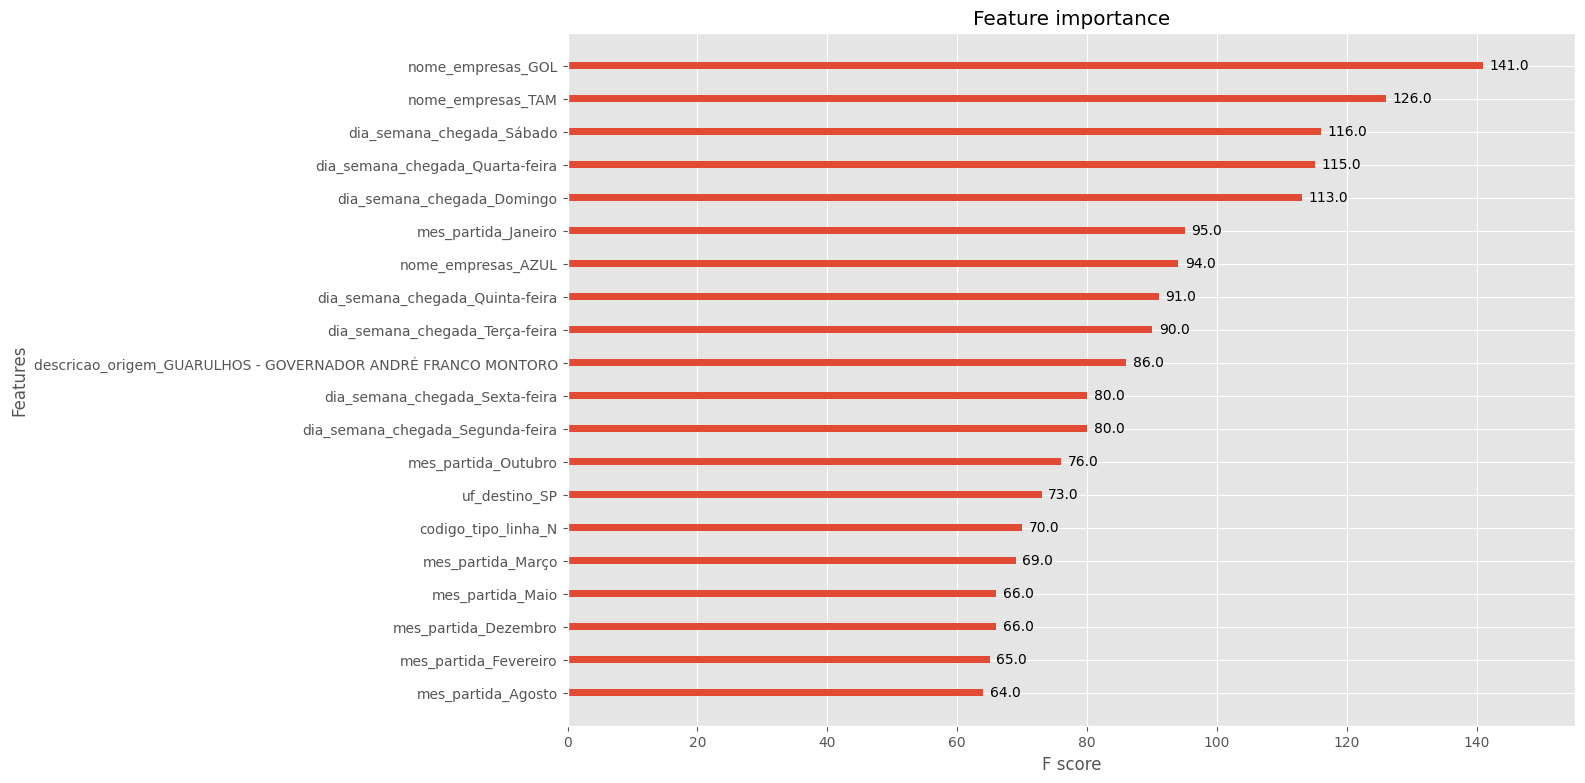

In [22]:
plt.rcParams['figure.figsize'] = [13, 9]
xgb.plot_importance(model_class, max_num_features=20)
plt.show()

### Treeplot

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.818254 to fit


<Figure size 5000x5000 with 0 Axes>

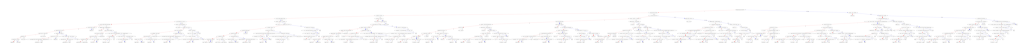

In [26]:
# plot single tree
#fig, ax = plt.subplots(figsize=(100, 100))
#fig = plt.figure(figsize=(12, 6))
plt.figure(figsize=(50, 50))
plot_tree(modelo)
#plt.savefig('xgb_treeplot.jpg', dpi=1800)  
plt.show()

## Matriz de Confusão

O gráfico de calor mostra as previsões do modelo em relação aos valores reais. Os valores na diagonal (7979 e 148171) representam as previsões corretas para as classes negativas (0) e positivas (1), respectivamente. Os outros dois valores (19805 e 18812) representam os erros do tipo I(falsos negativos) e tipo II(falsos positivos), respectivamente. A matriz sugere que o modelo é melhor em prever a classe majoritária (Pontual) do que a minoritária (Atraso), o que é comum em conjuntos de dados desbalanceados.

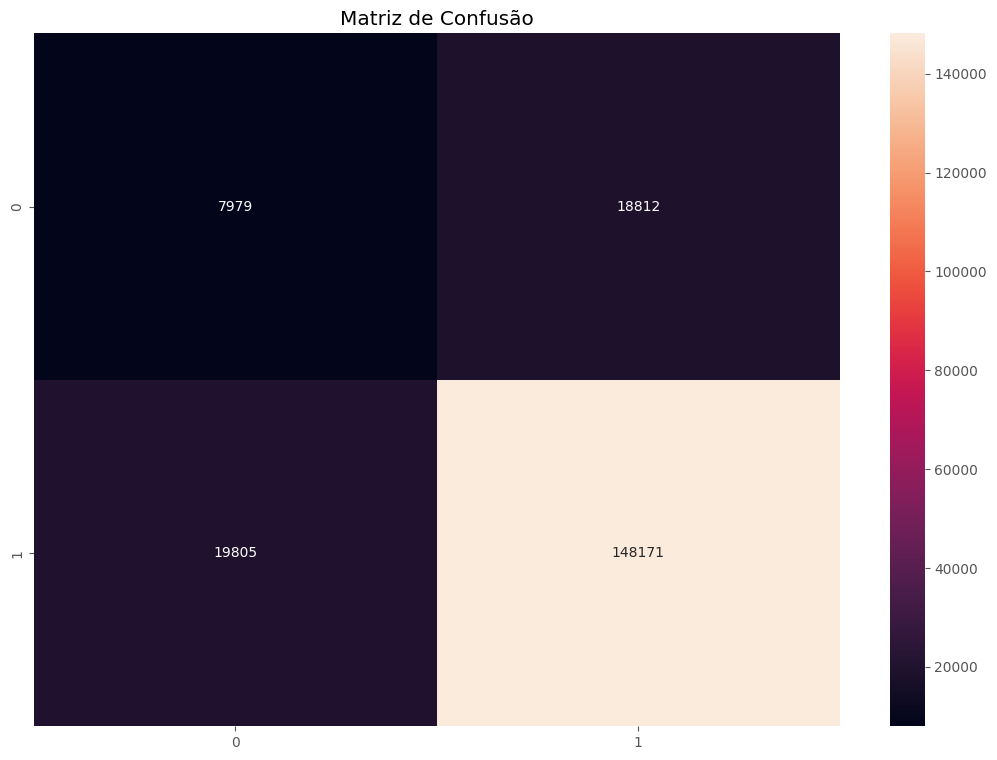

In [27]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusão')
plt.show()

## Curva ROC

A relação entre a taxa de verdadeiro positivo e a taxa de falso positivo para diferentes limiares de classificação. A curva está suave e sobe gradualmente. No entanto, uma curva ROC ideal se aproximaria mais do canto superior esquerdo mais rápido. A consequência é que temos uma alta taxa de verdadeiro positivo e baixa taxa de falso positivo. Isso devido ao banco de dados desbalanceado. O resultado nos permit dizer que ainda há um potencial de melhoria no modelo

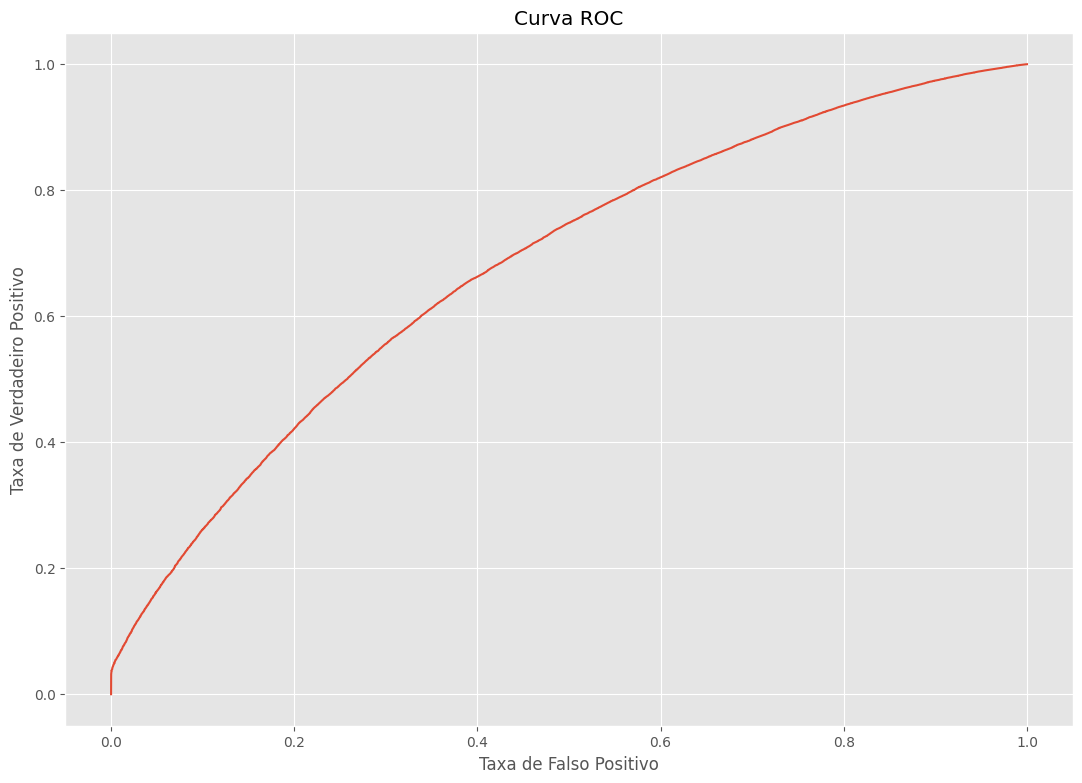

In [32]:
y_pred_proba_pos = y_pred_proba[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pos)
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.show()

## Curva de Precisão-Recall

Este gráfico é útil em situações de classes desbalanceadas e foca na relação entre precisão (quão muitos dos classificados como positivos são realmente positivos) e recall (quão muitos dos positivos reais foram capturados pelo modelo). A curva começa com uma alta precisão, mas diminui à medida que o recall aumenta, isso pode ser um sinal de que pode estar acontecendo um trade-off, ou seja, visando ter mais ou manter performance.

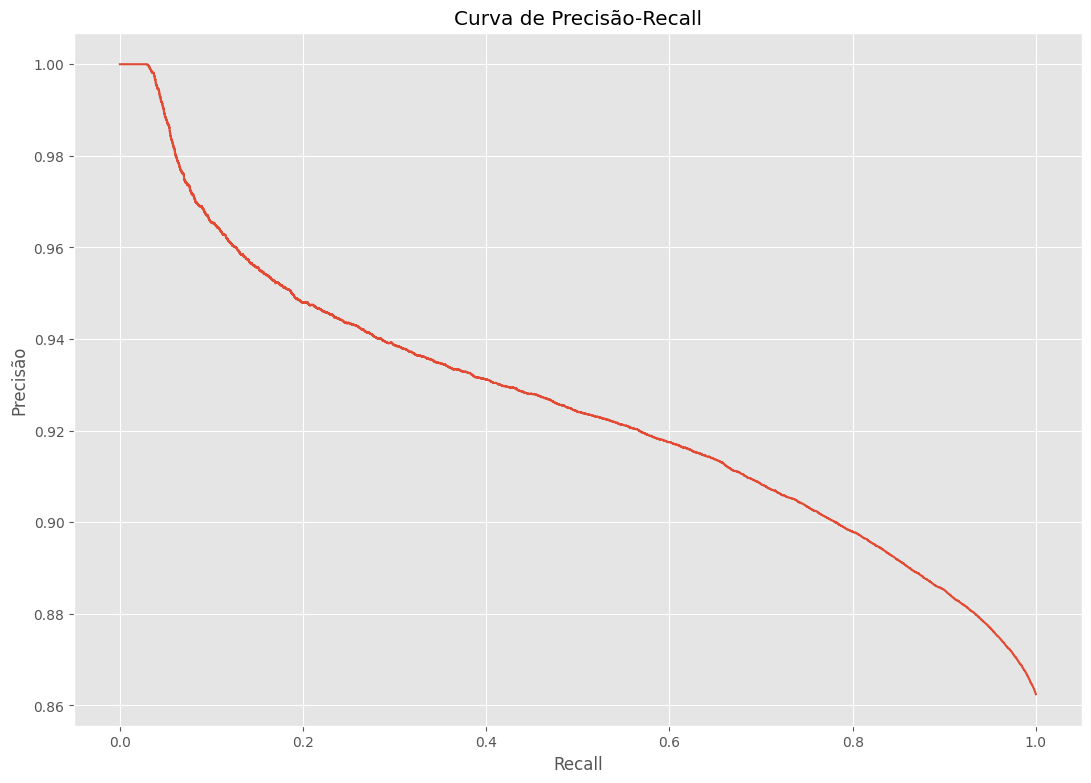

In [35]:
y_pred_proba_pos = y_pred_proba[:, 1]

# Curva de Precisão-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_pos)
plt.plot(recall, precision)
plt.title('Curva de Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

## Shap

O Shap nos permite compreender o peso de cada variavel para o modelo

In [36]:
explainer = shap.Explainer(modelo)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()

[16:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


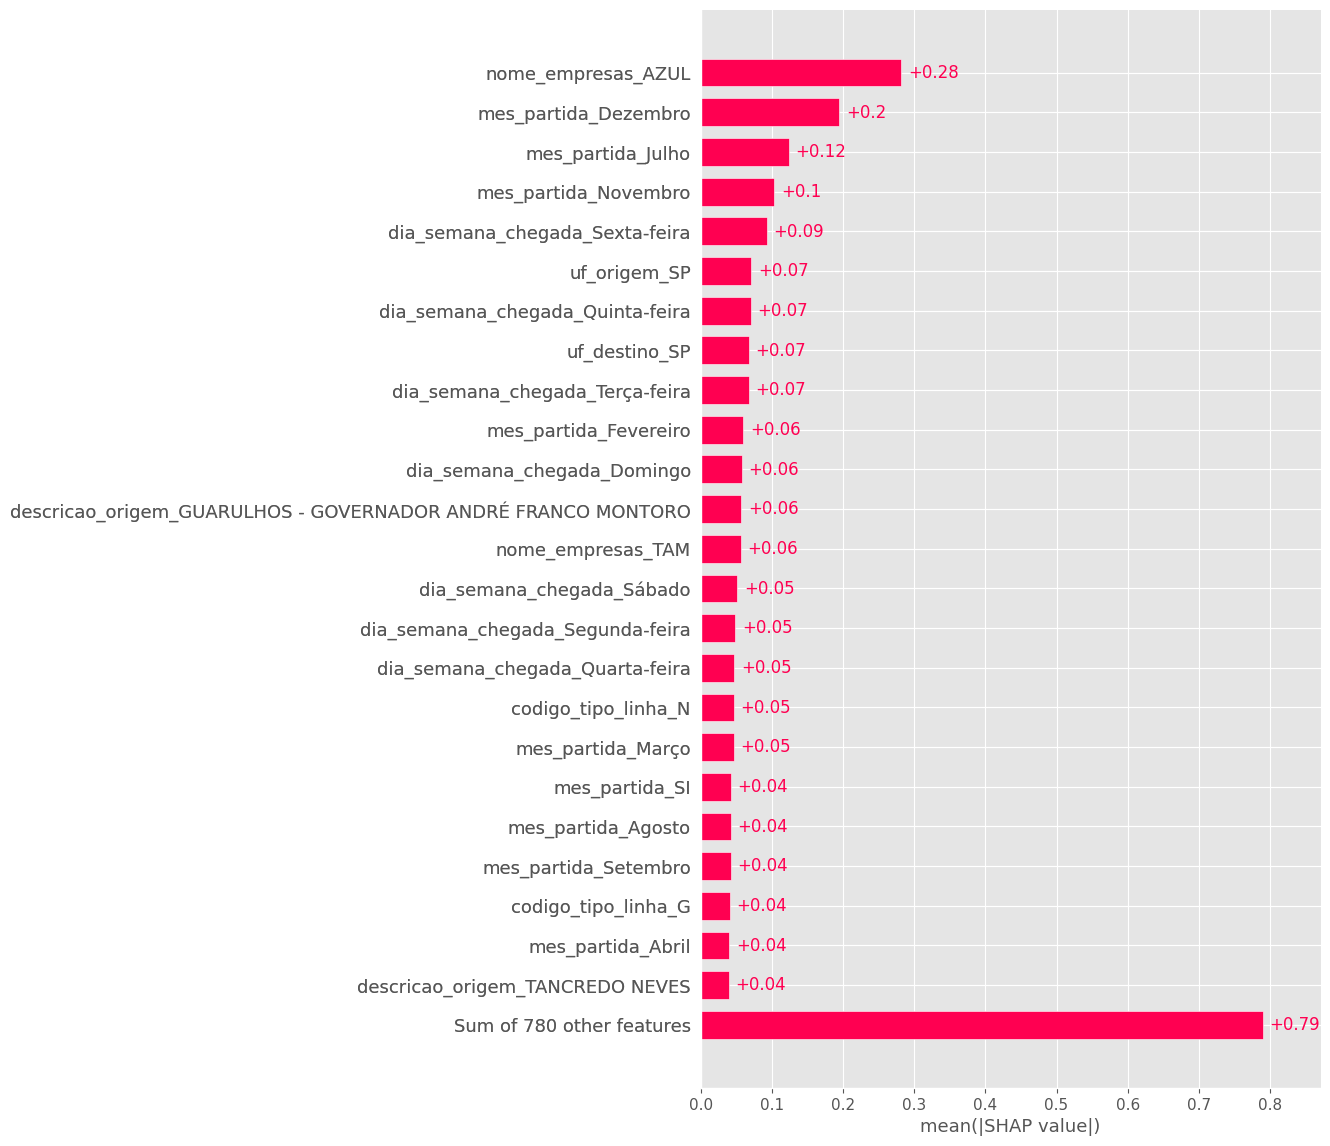

In [37]:
shap.plots.bar(shap_values, max_display=25)

# Salvando o Modelo

In [64]:
# Salvar o modelo
save_pickle(modelo, 'modelo/modelo_pkl/modelo_classificao.pkl')

# Load no modelo

In [65]:
# Carregar o modelo
modelo_carregado = load_pickle('modelo/modelo_pkl/modelo_classificao.pkl')

# Conclusões

Ao considerar todas essas métricas e gráficos em conjunto, podemos concluir que o modelo tem um desempenho mediano para bom, com uma boa precisão e recall. No entanto, a AUC indica que ainda há espaço para melhoria na capacidade do modelo de diferenciar entre as classes. Além disso, o modelo parece ser confiável em sua capacidade de identificar a classe positiva (alta precisão), e é capaz de capturar a maioria dos positivos reais (alto recall).<br>

Apesar dos resultados o modelo ainda carece de outras informações que poderiam ajudar a predizer melhor se o voo vai atrasar ou não, por exemplo:<br>

- Dados da meteorologia  o aeroporto de partida e de chegada<br>
- Quantidade de pessoas que estão abordas no voo<br>
- Informações da aeronova (quantidade de dias desde de sua última manutenção, modelo da aeronave)<br>
- Quantidade de pousos e decolagens previstos para o aeroporto naquele dia<br>
- Distância do voo<br>
- Tempo de voo do piloto<br>

Tais dimensões ajudariam a metrificar outros elementos que são capazes de interferir diretamente no atraso ou não do voo. <br>
